In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy.interpolate import griddata

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
# from psfex_fwhm_vs_nea.ipynb
fwhm_scaling = {'g': 0.963, 'r': 0.960, 'z': 0.952}

In [4]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_basic.fits', columns=['RA', 'DEC', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'MASKBITS', 'PHOTSYS', 'TARGETID', 'DESI_TARGET']))
cat1 = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_photom.fits', columns=['MORPHTYPE', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G']))
cat2 = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_sweep_1.fits', columns=['SHAPE_R', 'SHAPE_E1', 'SHAPE_E2']))
cat3 = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_sweep_2.fits', columns=['PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']))
cat4 = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/targets/dr9.0/1.1.1/resolve/dr9_elg_1.1.1_sweep_extra_1.fits', columns=['NEA_G', 'NEA_R', 'NEA_Z', 'BLOB_NEA_G', 'BLOB_NEA_R', 'BLOB_NEA_Z']))
cat = hstack([cat, cat1, cat2, cat3, cat4])
print(len(cat))

47217967


In [5]:
cat['gmag'] = 22.5 - 2.5*np.log10(np.clip(cat['FLUX_G']*10**(0.4*3.214*cat['EBV']), 1e-1, None))
cat['rmag'] = 22.5 - 2.5*np.log10(np.clip(cat['FLUX_R']*10**(0.4*2.165*cat['EBV']), 1e-1, None))
cat['zmag'] = 22.5 - 2.5*np.log10(np.clip(cat['FLUX_Z']*10**(0.4*1.211*cat['EBV']), 1e-1, None))
cat['gfibermag'] = 22.5 - 2.5*np.log10(np.clip(cat['FIBERFLUX_G']*10**(0.4*3.214*cat['EBV']), 1e-1, None))

In [6]:
mask_south = cat['PHOTSYS']=='S'
mask_south &= cat['DEC']>-20

mask = mask_south & (cat['MORPHTYPE']=='REX')
idx = np.where(mask)[0]

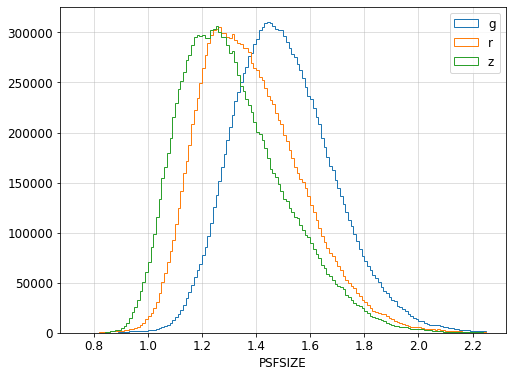

In [7]:
plt.figure(figsize=(8, 6))
for band in ['g', 'r', 'z']:
    band_upper = band.upper()
    plt.hist(cat['PSFSIZE_'+band_upper][idx], 150, range=(0.75, 2.25), histtype='step', label=band)
plt.xlabel('PSFSIZE')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [8]:
psfsizes = {'g': [1.1, 1.5, 2.0], 'r': [1.0, 1.3, 1.9], 'z': [0.95, 1.25, 1.9]}

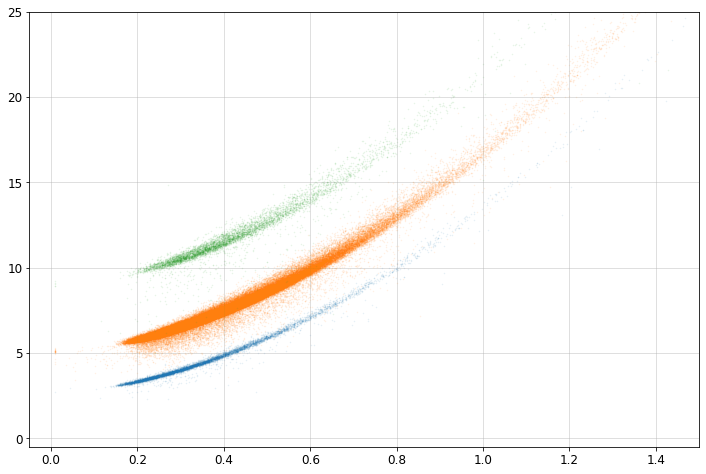

In [9]:
band = 'g'

plt.figure(figsize=(12, 8))
for psfsize in psfsizes['g']:
    mask = (cat['PSFSIZE_G'][idx]>psfsize) & (cat['PSFSIZE_G'][idx]<psfsize+0.005)
    plt.plot(cat['SHAPE_R'][idx[mask]], cat['NEA_G'][idx[mask]], '.', ms=1, alpha=0.1)
plt.axis([-0.05, 1.5, -0.5, 25])
plt.grid(alpha=0.5)
plt.show()

------
## g band

In [27]:
band = 'g'
band_upper = band.upper()
nea_path = '/global/cfs/cdirs/desi/users/rongpu/imaging_mc/nea/nea_vs_fwhm_{}_1024.fits'.format(band)

nea = Table(fitsio.read(nea_path))
nea_arr = np.array(nea['nea'])

hdr = fitsio.read_header(nea_path, ext=1)
shape_r_grid = np.arange(hdr['R_MIN'], hdr['R_MAX']+hdr['R_DELTA'], hdr['R_DELTA'])
fwhm_grid = np.array(nea['fwhm_bin'])

def nea_model(r, fwhm):
    points = np.array([r, fwhm]).T
    nea_predict = griddata(np.array([np.tile(shape_r_grid, len(nea)), np.repeat(np.array(nea['fwhm_mean']), len(shape_r_grid))]).T, nea_arr.flatten(), points, method='linear')
    if np.sum(np.isnan(nea_predict))>0:
        nea_predict_nearest = griddata(np.array([np.tile(shape_r_grid, len(nea)), np.repeat(np.array(nea['fwhm_mean']), len(shape_r_grid))]).T, nea_arr.flatten(), points, method='nearest')
        nea_predict[np.isnan(nea_predict)] = nea_predict_nearest[np.isnan(nea_predict)]
    return nea_predict

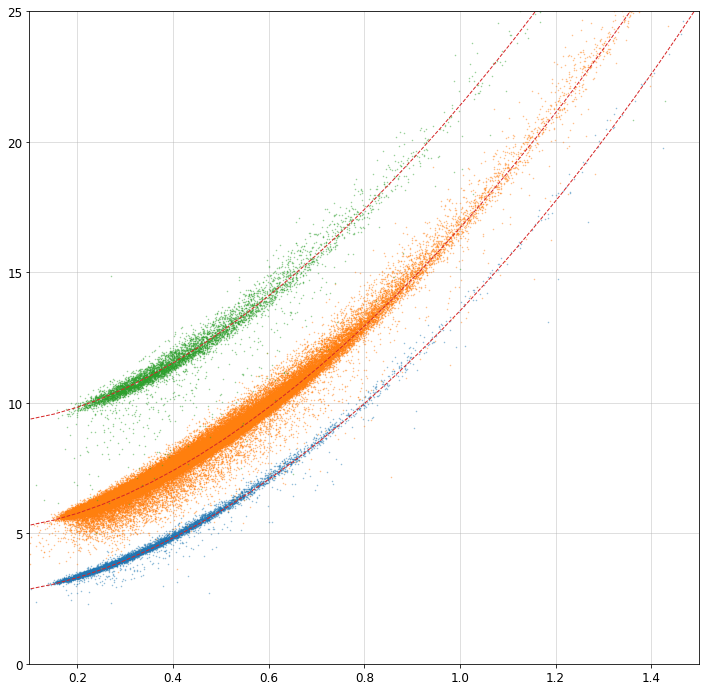

7585
149282
6210


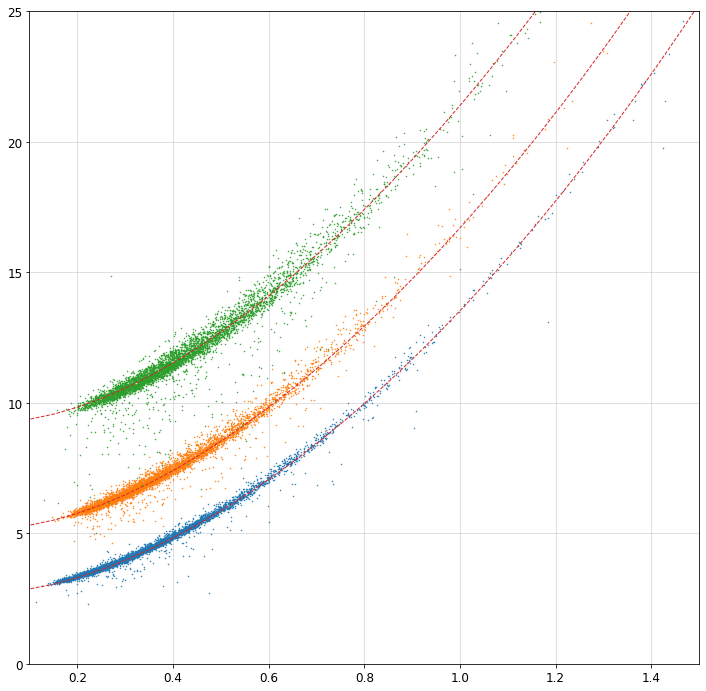

In [28]:
r_plot = np.linspace(0, 5, 100)
plt.figure(figsize=(12, 12))
for index, psfsize in enumerate(psfsizes[band]):
    mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
    plt.plot(cat['SHAPE_R'][idx[mask]], cat['NEA_'+band_upper][idx[mask]], 'C{}.'.format(index), ms=1, alpha=0.5)
    plt.plot(r_plot, nea_model(r_plot, np.repeat(fwhm_scaling[band]*np.mean(cat['PSFSIZE_'+band_upper][idx[mask]]), len(r_plot))), 'C3--', lw=1)
plt.axis([0.1, 1.5, 0, 25])
plt.grid(alpha=0.5)
plt.show()

# plot fewer points
np.random.seed(8123123)
r_plot = np.linspace(0, 5, 100)
plt.figure(figsize=(12, 12))
for index, psfsize in enumerate(psfsizes[band]):
    mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
    idx1 = np.where(mask)[0]
    if len(idx1)>5000:
        idx1 = np.random.choice(idx1, size=5000, replace=False)
    print(np.sum(mask))
    plt.plot(cat['SHAPE_R'][idx[idx1]], cat['NEA_'+band_upper][idx[idx1]], 'C{}.'.format(index), ms=1, alpha=1)
    plt.plot(r_plot, nea_model(r_plot, np.repeat(fwhm_scaling[band]*np.mean(cat['PSFSIZE_'+band_upper][idx[mask]]), len(r_plot))), 'C3--', lw=1)
plt.axis([0.1, 1.5, 0, 25])
plt.grid(alpha=0.5)
plt.show()

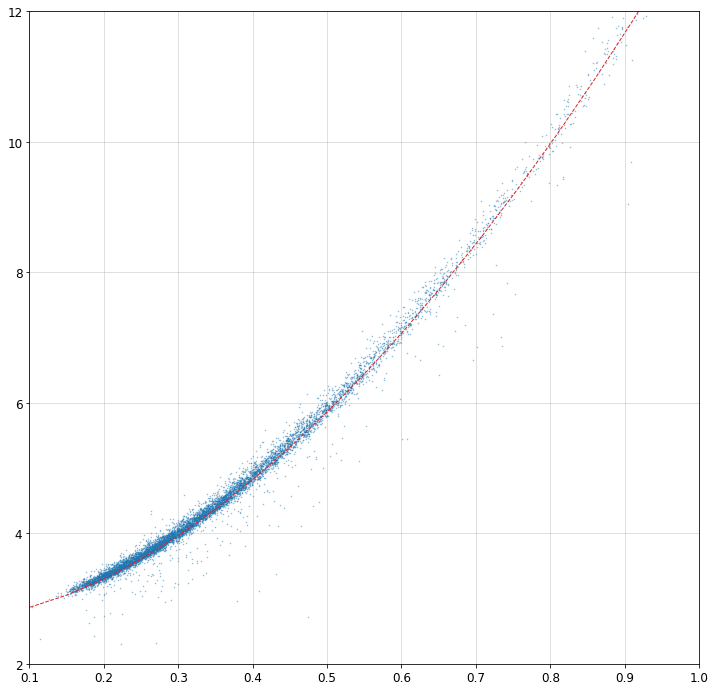

In [29]:
r_plot = np.linspace(0, 5, 100)
plt.figure(figsize=(12, 12))
index = 0
psfsize = psfsizes[band][index]
mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
plt.plot(cat['SHAPE_R'][idx[mask]], cat['NEA_'+band_upper][idx[mask]], 'C{}.'.format(index), ms=1, alpha=0.5)
plt.plot(r_plot, nea_model(r_plot, np.repeat(fwhm_scaling[band]*np.mean(cat['PSFSIZE_'+band_upper][idx[mask]]), len(r_plot))), 'C3--', lw=1)
plt.axis([0.1, 1., 2, 12])
plt.grid(alpha=0.5)
plt.show()

0.9932181372406169
0.9883965656947495
0.9944643920194182
1.0020176512145613


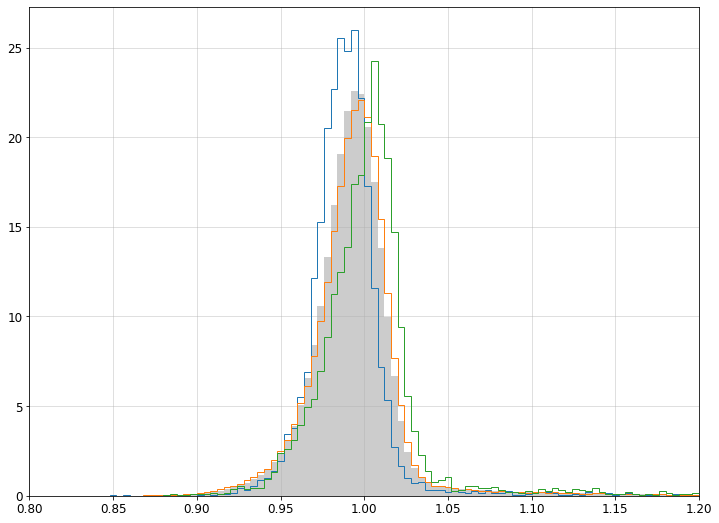

In [30]:
plt.figure(figsize=(12, 9))

np.random.seed(1231)
ii = np.random.choice(idx, size=int(1e6), replace=False)
nea_predict = nea_model(cat['SHAPE_R'][ii], fwhm_scaling[band]*cat['PSFSIZE_'+band_upper][ii])
print(np.median(nea_predict/cat['NEA_'+band_upper][ii]))
plt.hist(nea_predict/cat['NEA_'+band_upper][ii], 100, range=(0.8, 1.2), alpha=0.4, density=True, color='gray')

for index, psfsize in enumerate(psfsizes[band]):
    mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
    points = zip(cat['SHAPE_R'][idx[mask]], fwhm_scaling[band]*cat['PSFSIZE_'+band_upper][idx[mask]])
    nea_predict = nea_model(cat['SHAPE_R'][idx[mask]], fwhm_scaling[band]*cat['PSFSIZE_'+band_upper][idx[mask]])
    print(np.median(nea_predict/cat['NEA_'+band_upper][idx[mask]]))
    plt.hist(nea_predict/cat['NEA_'+band_upper][idx[mask]], 100, histtype='step', range=(0.8, 1.2), density=True)

plt.xlim(0.8, 1.2)
plt.grid(alpha=0.5)
plt.show()

------
## r band

In [31]:
band = 'r'
band_upper = band.upper()
nea_path = '/global/cfs/cdirs/desi/users/rongpu/imaging_mc/nea/nea_vs_fwhm_{}_1024.fits'.format(band)

nea = Table(fitsio.read(nea_path))
nea_arr = np.array(nea['nea'])

hdr = fitsio.read_header(nea_path, ext=1)
shape_r_grid = np.arange(hdr['R_MIN'], hdr['R_MAX']+hdr['R_DELTA'], hdr['R_DELTA'])
fwhm_grid = np.array(nea['fwhm_bin'])

def nea_model(r, fwhm):
    points = np.array([r, fwhm]).T
    nea_predict = griddata(np.array([np.tile(shape_r_grid, len(nea)), np.repeat(np.array(nea['fwhm_mean']), len(shape_r_grid))]).T, nea_arr.flatten(), points, method='linear')
    if np.sum(np.isnan(nea_predict))>0:
        nea_predict_nearest = griddata(np.array([np.tile(shape_r_grid, len(nea)), np.repeat(np.array(nea['fwhm_mean']), len(shape_r_grid))]).T, nea_arr.flatten(), points, method='nearest')
        nea_predict[np.isnan(nea_predict)] = nea_predict_nearest[np.isnan(nea_predict)]
    return nea_predict

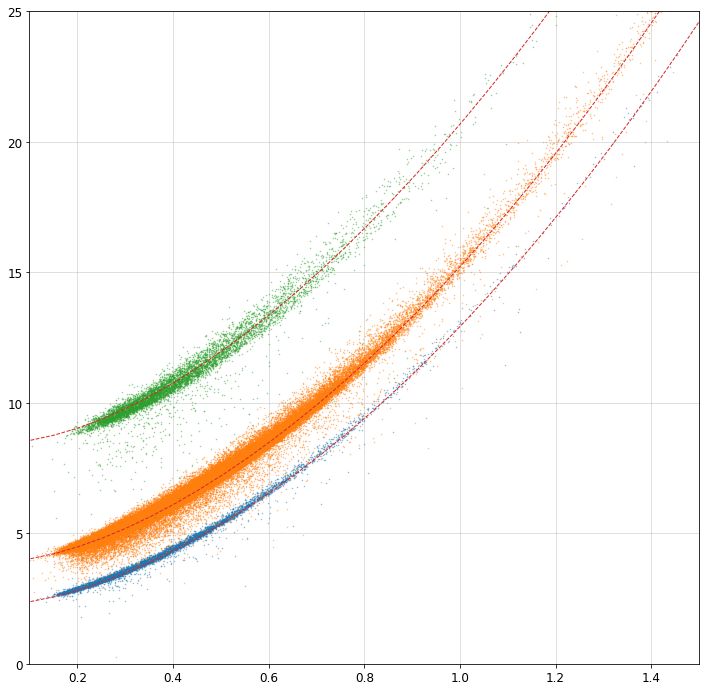

8205
147893
7133


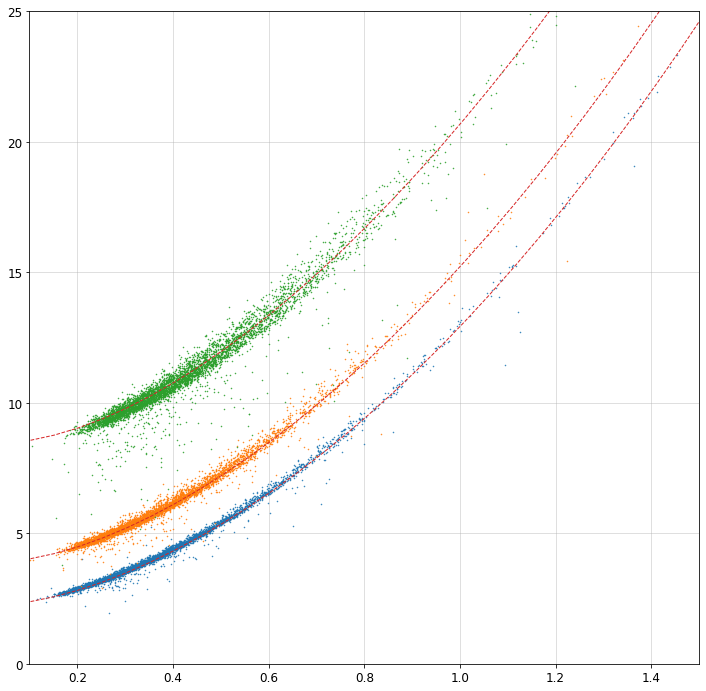

In [32]:
r_plot = np.linspace(0, 5, 100)
plt.figure(figsize=(12, 12))
for index, psfsize in enumerate(psfsizes[band]):
    mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
    plt.plot(cat['SHAPE_R'][idx[mask]], cat['NEA_'+band_upper][idx[mask]], 'C{}.'.format(index), ms=1, alpha=0.5)
    plt.plot(r_plot, nea_model(r_plot, np.repeat(fwhm_scaling[band]*np.mean(cat['PSFSIZE_'+band_upper][idx[mask]]), len(r_plot))), 'C3--', lw=1)
plt.axis([0.1, 1.5, 0, 25])
plt.grid(alpha=0.5)
plt.show()

# plot fewer points
np.random.seed(8123123)
r_plot = np.linspace(0, 5, 100)
plt.figure(figsize=(12, 12))
for index, psfsize in enumerate(psfsizes[band]):
    mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
    idx1 = np.where(mask)[0]
    if len(idx1)>5000:
        idx1 = np.random.choice(idx1, size=5000, replace=False)
    print(np.sum(mask))
    plt.plot(cat['SHAPE_R'][idx[idx1]], cat['NEA_'+band_upper][idx[idx1]], 'C{}.'.format(index), ms=1, alpha=1)
    plt.plot(r_plot, nea_model(r_plot, np.repeat(fwhm_scaling[band]*np.mean(cat['PSFSIZE_'+band_upper][idx[mask]]), len(r_plot))), 'C3--', lw=1)
plt.axis([0.1, 1.5, 0, 25])
plt.grid(alpha=0.5)
plt.show()

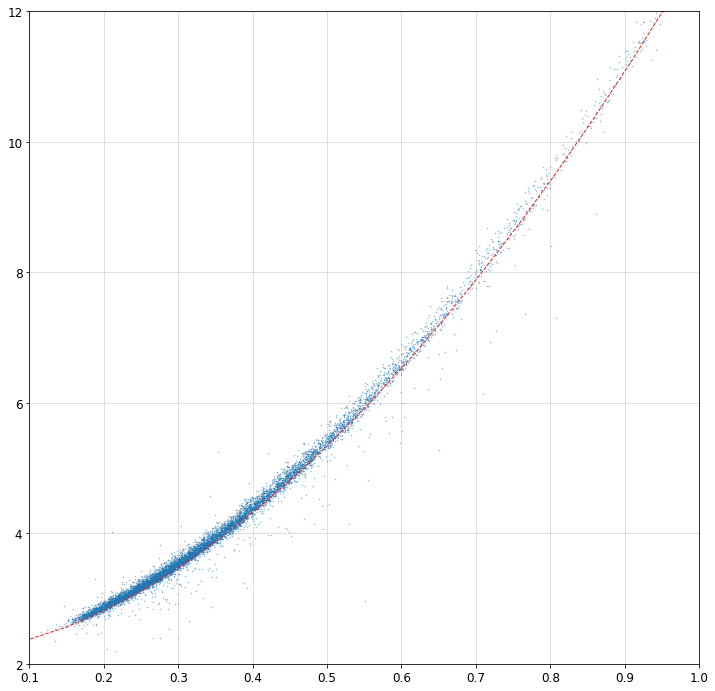

In [33]:
r_plot = np.linspace(0, 5, 100)
plt.figure(figsize=(12, 12))
index = 0
psfsize = psfsizes[band][index]
mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
plt.plot(cat['SHAPE_R'][idx[mask]], cat['NEA_'+band_upper][idx[mask]], 'C{}.'.format(index), ms=1, alpha=0.5)
plt.plot(r_plot, nea_model(r_plot, np.repeat(fwhm_scaling[band]*np.mean(cat['PSFSIZE_'+band_upper][idx[mask]]), len(r_plot))), 'C3--', lw=1)
plt.axis([0.1, 1., 2, 12])
plt.grid(alpha=0.5)
plt.show()

0.9925054366276214
0.9821898574567341
0.9921187589004943
1.0057918016312588


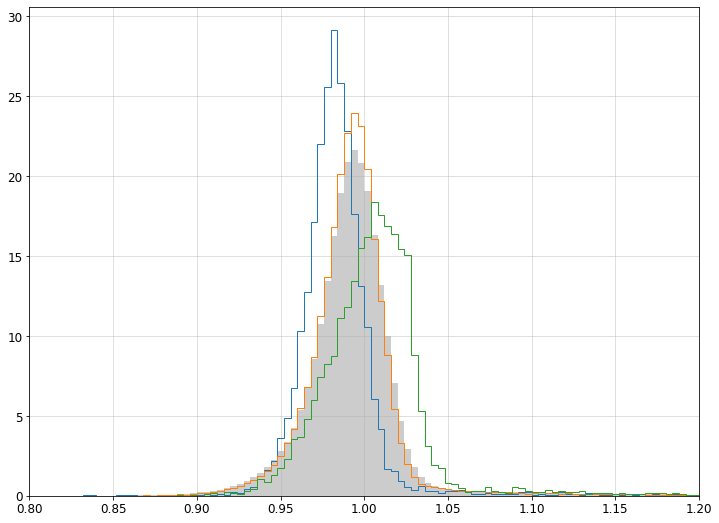

In [34]:
plt.figure(figsize=(12, 9))

np.random.seed(1231)
ii = np.random.choice(idx, size=int(1e6), replace=False)
nea_predict = nea_model(cat['SHAPE_R'][ii], fwhm_scaling[band]*cat['PSFSIZE_'+band_upper][ii])
print(np.median(nea_predict/cat['NEA_'+band_upper][ii]))
plt.hist(nea_predict/cat['NEA_'+band_upper][ii], 100, range=(0.8, 1.2), alpha=0.4, density=True, color='gray')

for index, psfsize in enumerate(psfsizes[band]):
    mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
    points = zip(cat['SHAPE_R'][idx[mask]], fwhm_scaling[band]*cat['PSFSIZE_'+band_upper][idx[mask]])
    nea_predict = nea_model(cat['SHAPE_R'][idx[mask]], fwhm_scaling[band]*cat['PSFSIZE_'+band_upper][idx[mask]])
    print(np.median(nea_predict/cat['NEA_'+band_upper][idx[mask]]))
    plt.hist(nea_predict/cat['NEA_'+band_upper][idx[mask]], 100, histtype='step', range=(0.8, 1.2), density=True)

plt.xlim(0.8, 1.2)
plt.grid(alpha=0.5)
plt.show()

------
## z band

In [35]:
band = 'z'
band_upper = band.upper()
nea_path = '/global/cfs/cdirs/desi/users/rongpu/imaging_mc/nea/nea_vs_fwhm_{}_1024.fits'.format(band)

nea = Table(fitsio.read(nea_path))
nea_arr = np.array(nea['nea'])

hdr = fitsio.read_header(nea_path, ext=1)
shape_r_grid = np.arange(hdr['R_MIN'], hdr['R_MAX']+hdr['R_DELTA'], hdr['R_DELTA'])
fwhm_grid = np.array(nea['fwhm_bin'])

def nea_model(r, fwhm):
    points = np.array([r, fwhm]).T
    nea_predict = griddata(np.array([np.tile(shape_r_grid, len(nea)), np.repeat(np.array(nea['fwhm_mean']), len(shape_r_grid))]).T, nea_arr.flatten(), points, method='linear')
    if np.sum(np.isnan(nea_predict))>0:
        nea_predict_nearest = griddata(np.array([np.tile(shape_r_grid, len(nea)), np.repeat(np.array(nea['fwhm_mean']), len(shape_r_grid))]).T, nea_arr.flatten(), points, method='nearest')
        nea_predict[np.isnan(nea_predict)] = nea_predict_nearest[np.isnan(nea_predict)]
    return nea_predict

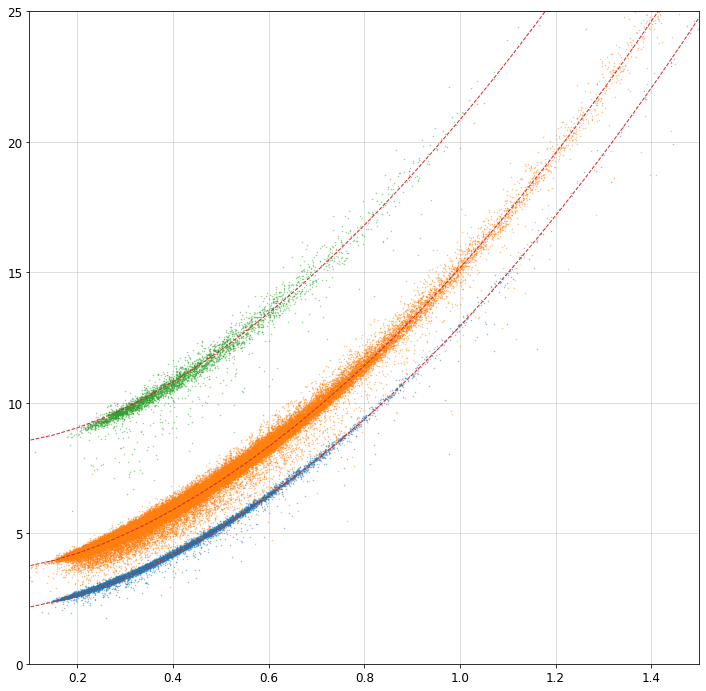

12792
152724
3692


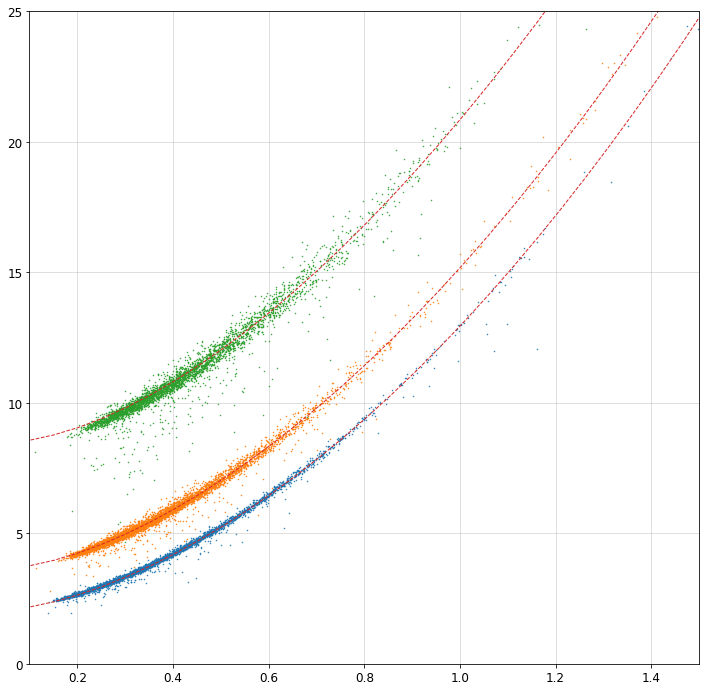

In [36]:
r_plot = np.linspace(0, 5, 100)
plt.figure(figsize=(12, 12))
for index, psfsize in enumerate(psfsizes[band]):
    mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
    plt.plot(cat['SHAPE_R'][idx[mask]], cat['NEA_'+band_upper][idx[mask]], 'C{}.'.format(index), ms=1, alpha=0.5)
    plt.plot(r_plot, nea_model(r_plot, np.repeat(fwhm_scaling[band]*np.mean(cat['PSFSIZE_'+band_upper][idx[mask]]), len(r_plot))), 'C3--', lw=1)
plt.axis([0.1, 1.5, 0, 25])
plt.grid(alpha=0.5)
plt.show()

# plot fewer points
np.random.seed(8123123)
r_plot = np.linspace(0, 5, 100)
plt.figure(figsize=(12, 12))
for index, psfsize in enumerate(psfsizes[band]):
    mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
    idx1 = np.where(mask)[0]
    if len(idx1)>5000:
        idx1 = np.random.choice(idx1, size=5000, replace=False)
    print(np.sum(mask))
    plt.plot(cat['SHAPE_R'][idx[idx1]], cat['NEA_'+band_upper][idx[idx1]], 'C{}.'.format(index), ms=1, alpha=1)
    plt.plot(r_plot, nea_model(r_plot, np.repeat(fwhm_scaling[band]*np.mean(cat['PSFSIZE_'+band_upper][idx[mask]]), len(r_plot))), 'C3--', lw=1)
plt.axis([0.1, 1.5, 0, 25])
plt.grid(alpha=0.5)
plt.show()

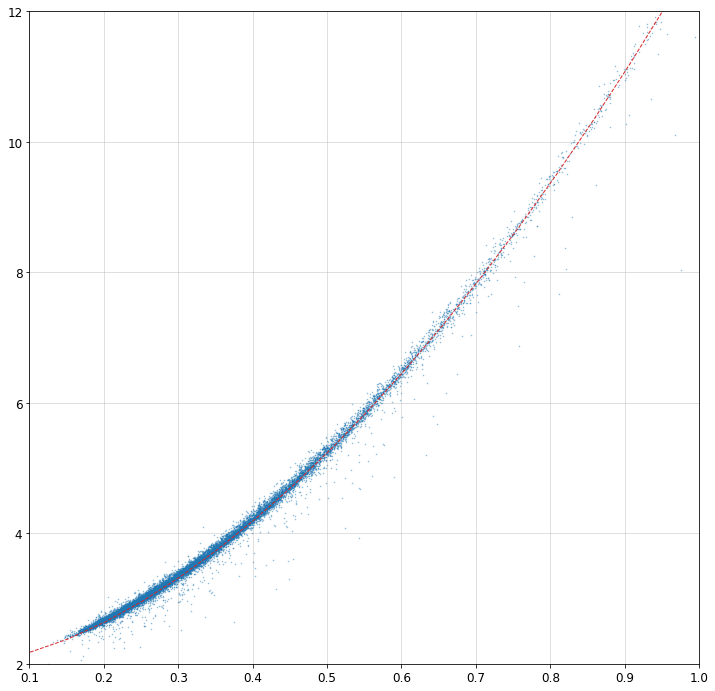

In [37]:
r_plot = np.linspace(0, 5, 100)
plt.figure(figsize=(12, 12))
index = 0
psfsize = psfsizes[band][index]
mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
plt.plot(cat['SHAPE_R'][idx[mask]], cat['NEA_'+band_upper][idx[mask]], 'C{}.'.format(index), ms=1, alpha=0.5)
plt.plot(r_plot, nea_model(r_plot, np.repeat(fwhm_scaling[band]*np.mean(cat['PSFSIZE_'+band_upper][idx[mask]]), len(r_plot))), 'C3--', lw=1)
plt.axis([0.1, 1., 2, 12])
plt.grid(alpha=0.5)
plt.show()

0.9980308425278905
0.9907034345100327
1.000603028461967
1.006817205977665


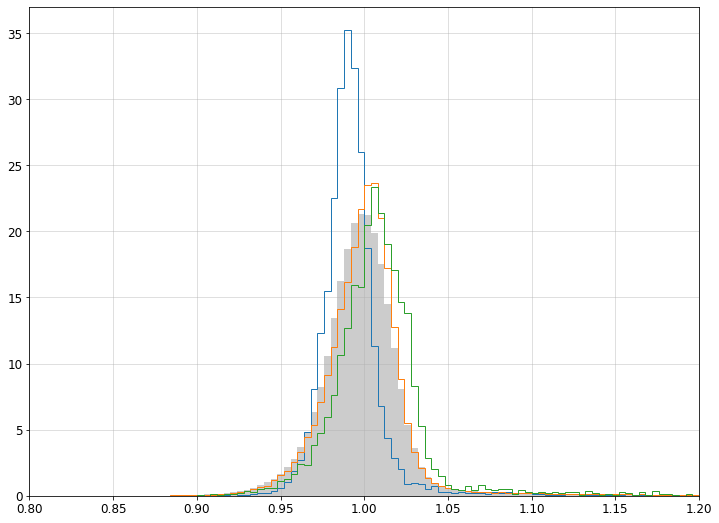

In [38]:
plt.figure(figsize=(12, 9))

np.random.seed(1231)
ii = np.random.choice(idx, size=int(1e6), replace=False)
nea_predict = nea_model(cat['SHAPE_R'][ii], fwhm_scaling[band]*cat['PSFSIZE_'+band_upper][ii])
print(np.median(nea_predict/cat['NEA_'+band_upper][ii]))
plt.hist(nea_predict/cat['NEA_'+band_upper][ii], 100, range=(0.8, 1.2), alpha=0.4, density=True, color='gray')

for index, psfsize in enumerate(psfsizes[band]):
    mask = (cat['PSFSIZE_'+band_upper][idx]>psfsize) & (cat['PSFSIZE_'+band_upper][idx]<psfsize+0.005)
    points = zip(cat['SHAPE_R'][idx[mask]], fwhm_scaling[band]*cat['PSFSIZE_'+band_upper][idx[mask]])
    nea_predict = nea_model(cat['SHAPE_R'][idx[mask]], fwhm_scaling[band]*cat['PSFSIZE_'+band_upper][idx[mask]])
    print(np.median(nea_predict/cat['NEA_'+band_upper][idx[mask]]))
    plt.hist(nea_predict/cat['NEA_'+band_upper][idx[mask]], 100, histtype='step', range=(0.8, 1.2), density=True)

plt.xlim(0.8, 1.2)
plt.grid(alpha=0.5)
plt.show()